# Modelo predictivo exponencial

El propósito de este notebook es construir un modelo predictivo de la forma:

$N_{t} = \alpha_{t-1} \cdot N_{t-1}$

O sea, un simple modelo exponencial con coeficiente variable. Proponemos modelar $\alpha_t$, la variable de _infection rate_, como una dependencia de un conjunto de factores demográficos y de comportamiento, entre los que sería deseable incluir:

* Datos demográficos:
    * Población / densidad poblacional
    * PIB per cápita
    * Índice de desarrollo humano
    * Urbanización
* Datos específicos de la epidemia
    * Días en cuarentena
    * Tipo de cuarentena en vigor (nacional, estatal, local)
    * Existencia de un sistema de salud generalizado

## Datos importados

Primero vamos a cargar los datos demográficos, de cuarentena, y cantidad de infectados detectados cada día.

In [58]:
import pandas as pd
import json

demographic_data = pd.read_csv("../data/world_demographics.tsv", sep="\t").set_index("Country")
display(demographic_data.head())

quarantine_data = pd.read_csv("../data/quarantine.tsv", sep="\t").fillna("")
for col in ['Start date', 'End date']:
    quarantine_data[col] = pd.to_datetime(quarantine_data[col])
quarantine_data = quarantine_data.groupby('Country').agg(
    start=('Start date', 'min'),
    end=('End date', 'max'),
    level=('Level', 'first')
)
display(quarantine_data.head())

with open("../data/timeseries.json") as fp:
    infection_data = json.load(fp)
    infection_data = {country: [datum['confirmed'] - datum['recovered'] - datum['deaths'] for datum in data] for country, data in infection_data.items()}
    infection_data = pd.DataFrame([{'Country': k, 'Data': v} for k,v in infection_data.items()]).set_index('Country')
    
display(infection_data)

,Population,Yearly change,Net change,Density,Land area,Migrants,Fertility,Med. age,Urban,World share
Country,,,,,,,,,,
China,1439323776,0.39,5540090,153,9388211,-348399.0,1.7,38,61,18.47
India,1380004385,0.99,13586631,464,2973190,-532687.0,2.2,28,35,17.70
United States,331002651,0.59,1937734,36,9147420,954806.0,1.8,38,83,4.25
Indonesia,273523615,1.07,2898047,151,1811570,-98955.0,2.3,30,56,3.51
Pakistan,220892340,2.00,4327022,287,770880,-233379.0,3.6,23,35,2.83


,start,end,level
Country,,,
Argentina,2020-03-19,2020-03-31,National
Australia,2020-03-23,2020-09-22,National
Austria,2020-03-16,2020-04-13,National
Azad Kashmir,2020-03-24,2020-04-07,Administrative
Balochistan,2020-03-24,2020-04-07,Province


,Data
Country,
Afghanistan,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Albania,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Algeria,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Andorra,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Angola,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
Mali,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Saint Kitts and Nevis,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Kosovo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Calculando características demográficas

Por cada país, obtendremos las principales características demográficas.

In [59]:
def extract_global_features(country:str, demographics_data:dict):
    return dict(
        country=country,
        population=demographics_data.get(country).get('Population'),
        density=demographics_data.get(country).get('Density'),
        fertility=demographics_data.get(country).get('Fertility'),
        mid_age=demographics_data.get(country).get('Med. age'),
        urbanization=demographics_data.get(country).get('Urban'),
    )

extract_global_features('Cuba', demographic_data.to_dict('index'))

{'country': 'Cuba',
 'population': 11326616,
 'density': 106,
 'fertility': 1.6,
 'mid_age': 42,
 'urbanization': 78}

## Características epidemiológicas

Por cada país, por cada día de información, obtendremos las características epidemiológicas de dicho día: cantidad de infectados, ritmo de infección, y estado de la cuarentena.

In [76]:
import datetime

def extract_timeseries_features(
    country:str, 
    quarantine_data:dict, 
    infection_data:dict,
    last_date:datetime.date=datetime.date(2020,3,25), # Fecha de última actualización (último día en la serie de tiempo)
    days_back:int=0,                                  # Cantidad de días a mirar hacia atrás
    min_reports:int=1,                                # Cantidad mínima de reportes para entrenar
    smooth_factor:float=0.9
):
    infection_totals = infection_data[country]['Data']
    total_days = len(infection_totals)
    start_date = last_date - datetime.timedelta(days=total_days-1)
    
    samples = []
    
    for day in range(days_back, len(infection_totals)):
        total_today = infection_totals[day]
        current_date = start_date + datetime.timedelta(days=day)
        
        if total_today < min_reports:
            continue
        
        # Datos de hoy
        data = dict(
            day=day,
            date=(current_date - datetime.date(2020,1,1)).days,
            infections=total_today,
            new_infections=total_today - infection_totals[day-1],
        )
        
        if day > 0 and infection_totals[day-1] > 0:
            data['rate'] = total_today / infection_totals[day-1]
        else:
            data['rate'] = 1      
        
        # Datos de infección de los K días anteriores
        for j in range(1, days_back+1):
            data[f"infections_prev_{j}"] = infection_totals[day - j]    
            
        # Datos de cuarentena
        quarantine_start = quarantine_data.get(country, {}).get('start', None)
        quarantine_end = quarantine_data.get(country, {}).get('end', None)
        
        if quarantine_start is not None and quarantine_start.date() <= current_date and (quarantine_end is None or quarantine_end.date() > current_date):
            data['quarantine_days'] = max(0, (current_date - quarantine_start.date()).days + 1)
            data['quarantine_level'] = quarantine_data[country]['level']
        else:
            data['quarantine_days'] = 0
            data['quarantine_level'] = "None"
        
        samples.append(data)
        
    # Aplicar smoothing
    def smooth(key):
        for i, sample in enumerate(samples):
            smooth = 1

            for j in range(0, i+1):
                smooth = smooth * smooth_factor + samples[j][key] * (1 - smooth_factor)

            sample['smooth_%s' % key] = smooth
            
    smooth('infections')
    samples[0]['increment'] = 0
    for i in range(1, len(samples)):
        samples[i]['increment'] = samples[i]['smooth_infections'] - samples[i-1]['smooth_infections']
        
    smooth('increment')
    samples[0]['curvature'] = 0
    for i in range(1, len(samples)):
        samples[i]['curvature'] = samples[i]['smooth_increment'] - samples[i-1]['smooth_increment']
    
    smooth('curvature')
        
    return samples

In [77]:
extract_timeseries_features('Cuba', quarantine_data.to_dict("index"), infection_data.to_dict("index"))[-1]

{'day': 66,
 'date': 84,
 'infections': 112,
 'new_infections': 38,
 'rate': 1.5135135135135136,
 'quarantine_days': 0,
 'quarantine_level': 'None',
 'smooth_infections': 37.14807035915047,
 'increment': 8.316881071205497,
 'smooth_increment': 2.8437543242168672,
 'curvature': 0.6081251941098476,
 'smooth_curvature': 0.3337169680580296}

## Mezclando todo

Luego construimos un dataset por cada día de cada país con la unión de todos los datos. De esta manera desacoplamos el factor temporal y convertimos el modelo en estacionario, donde cada día la variable a predecir es el `rate` de infección dado el estado de dicho día.

In [78]:
demographic_dict = demographic_data.to_dict('index')
quarantine_dict = quarantine_data.to_dict('index')
infection_dict = infection_data.to_dict('index')

def extract_features(country, last_date=datetime.date(2020,3,25), days_back=0, min_reports=10):
    try:
        global_features = extract_global_features(country, demographic_dict)
    except AttributeError:
        return []

#     global_features = {}
    timeseries_features = [
        dict(features, **global_features) 
        for features in extract_timeseries_features(
            country, quarantine_dict, infection_dict, last_date, days_back
        )
    ]
    
    for t in timeseries_features:
        t['infected_per_million'] = t['infections'] / 1000000 / t['population']
    
    return timeseries_features

all_features = []

for country in infection_dict:
    all_features.extend(extract_features(country, days_back=0))
    
all_features_df = pd.DataFrame(all_features)
all_features_df.head()

,day,date,infections,new_infections,rate,quarantine_days,quarantine_level,smooth_infections,increment,smooth_increment,curvature,smooth_curvature,country,population,density,fertility,mid_age,urbanization,infected_per_million
0,33,51,1,1,1.0,0,None,1.0,0.0,0.90000,0.00000,0.900000,Afghanistan,38928346,60,4.6,18,25,2.568822e-14
1,34,52,1,0,1.0,0,None,1.0,0.0,0.81000,-0.09000,0.801000,Afghanistan,38928346,60,4.6,18,25,2.568822e-14
2,35,53,1,0,1.0,0,None,1.0,0.0,0.72900,-0.08100,0.712800,Afghanistan,38928346,60,4.6,18,25,2.568822e-14
3,36,54,1,0,1.0,0,None,1.0,0.0,0.65610,-0.07290,0.634230,Afghanistan,38928346,60,4.6,18,25,2.568822e-14
4,37,55,1,0,1.0,0,None,1.0,0.0,0.59049,-0.06561,0.564246,Afghanistan,38928346,60,4.6,18,25,2.568822e-14


## Visualizando los datos

Veamos algunas visualizaciones interesantes de estos datos.

### Países con mayor cantidad de infecciones

In [79]:
import altair as alt

def plot(countries):
    countries_data = all_features_df[all_features_df['country'].isin(countries)]
    
    return alt.Chart(countries_data).mark_line().encode(
        x='day',
        y='infections',
        color='country',
    ) | alt.Chart(countries_data).mark_line().encode(
        x='day',
        y='smooth_curvature',
        color='country',
    )

plot(['China', 'Italy', 'Spain', 'United States'])

alt.HConcatChart(...)

### Paises que han hecho un buen trabajo conteniendo la epidemia

In [81]:
plot(['South Korea', 'Japan'])

alt.HConcatChart(...)

## Construyendo el modelo

Con los datos anteriores podemos construir un modelo predictivo, donde la variable independiente es `rate` y todas las demás son variables dependientes (excepto `date` que solo está para depurar el modelo, pero no debe ser usada en la predicción).

Lo primero es construir un conjunto de entrenamiento.

In [87]:
from sklearn.feature_extraction import DictVectorizer
import numpy as np

model_features = [
    'quarantine_days'
]

def build_training_set(features, vectorizer=None):
    X = [{k:v for k,v in f.items() if k in model_features} for f in features]
    
    if vectorizer:
        X = vectorizer.transform(X)
    else:
        vectorizer = DictVectorizer(sparse=False)
        X = vectorizer.fit_transform(X)
        
    y = [f['curvature'] for f in features]
    y = np.asarray(y)

    return X,y,vectorizer

X,y,vectorizer = build_training_set(all_features)
vectorizer.inverse_transform(X)[0]

{}

Ahora construiremos un modelo predictivo usando un regresor lineal. Vamos a utilizar una estrategia de cross-validation para obtener los mejores parámetros de dicho modelo.

In [88]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

model = DecisionTreeRegressor(max_depth=4, min_samples_split=100, min_samples_leaf=100)
model.fit(X, y)
model.score(X, y)

0.12737885629010015

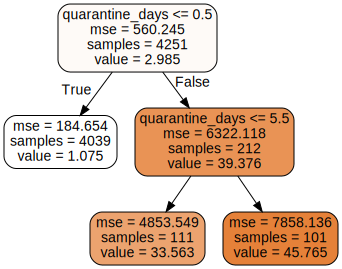

In [89]:
import graphviz

graph = export_graphviz(model, feature_names=vectorizer.feature_names_, filled=True, rounded=True)
graphviz.Source(graph)

In [90]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.11007278699668632